In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
arabic_stopwords = nltk.corpus.stopwords.words("arabic")
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
def preprocess(text):
    tweet=(re.sub(r'[^\w\s]', ' ', text))
    tweet=(re.sub(r'\w*_\w*', '', tweet))
    tweet=re.sub(r'http\S+', '',tweet)
    tweet=re.sub(r'ه\s','ة ' ,tweet)
    tweet = re.sub(r"إ", "ا", tweet)
    tweet = re.sub(r"أ", "ا", tweet)
    tweet = re.sub(r"آ", "ا", tweet)
    tweet = re.sub(r"ى", "ي", tweet)
    tweet = re.sub(r"اللة", "الله", tweet)
    tweet = ' '.join([word for word in tweet.split() if word not in arabic_stopwords])
    tweet = re.sub(arabic_diacritics,"", tweet)
    tweet=(re.sub(r'^\w\s', ' ', tweet))
    tweet=(re.sub(r'[A-Za-z]', ' ', tweet))
    tweet = re.sub(r'\d', '',tweet)
    return tweet

In [11]:
train_data = pd.read_csv("train.csv")
dev_data = pd.read_csv("dev.csv")

In [12]:
train_category= np.array(train_data['category'].tolist())
train_stance=np.array(train_data['stance'].tolist())
train_text = np.array(train_data['text'].tolist())

for i in range(len(train_text)):
    train_text[i] = preprocess(train_text[i])

dev_category= np.array(dev_data['category'].tolist())
dev_stance=np.array(dev_data['stance'].tolist())
dev_text = np.array(dev_data['text'].tolist())

for i in range(len(dev_text)):
    dev_text[i] = preprocess(dev_text[i])

In [13]:
# the Bag of Words features

tokenized_data=[]
for i in train_text:
    tokenized_data.append( nltk.tokenize.wordpunct_tokenize(i))

print(tokenized_data[0])
word2count = {} # it is the vocab 
for sent in tokenized_data:
	for word in sent:
		if word not in word2count.keys():
			word2count[word] = 1
		else:
			word2count[word] += 1

print(len(word2count.keys()))
vocabsize=len(word2count.keys())

['بيل', 'غيتس', 'يتلقي', 'لقاح', 'كوفيد', 'تصوير', 'الابرة', 'السيرنجة', 'الدواء', 'لابس', 'بولو', 'صيفي', 'عز', 'الشتاء', 'يقول', 'ان', 'احدي', 'مزايا', 'عمر', 'ال', 'عام', 'انة', 'مؤهل', 'للحصول', 'علي', 'اللقاح', 'يعني', 'يحتاج', 'اللقاح', 'عمرة', 'اصغر']
25444


In [14]:
# change catogary train and catodray dev to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_category)
category_encode = le.transform(train_category)
print(category_encode[1:10])
print(train_category[1:10])
le = preprocessing.LabelEncoder()
le.fit(dev_category)
devcategory_encode = le.transform(dev_category)
print(devcategory_encode[1:10])
print(dev_category[1:10])


[2 2 1 4 2 2 4 9 2]
['info_news' 'info_news' 'celebrity' 'personal' 'info_news' 'info_news'
 'personal' 'unrelated' 'info_news']
[5 1 2 2 2 5 2 2 2]
['plan' 'celebrity' 'info_news' 'info_news' 'info_news' 'plan' 'info_news'
 'info_news' 'info_news']


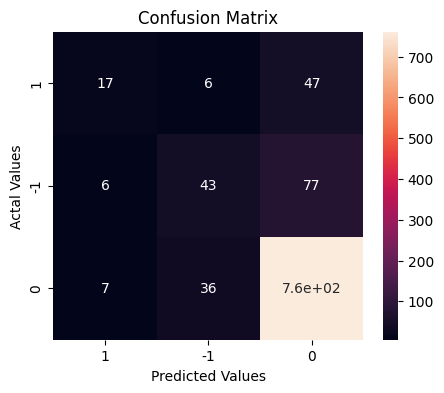

Accuracy:  0.821
Macro f1 score:  0.5495692881267789
Micro f1 score:  0.821


In [15]:
# SVM   CountVectorizer   TfidfTransformer    1 0 -1
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
                         ('tfidf', TfidfTransformer(use_idf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge',penalty='l2',alpha=0.0001, n_iter_no_change=5, random_state=42)) ])

text_clf_svm.fit(train_text, train_stance)
predicted_svm = text_clf_svm.predict(dev_text)


#confussion matrix
confusion_matrix = metrics.confusion_matrix(dev_stance, predicted_svm)
cm_df = pd.DataFrame(confusion_matrix,index = ['1','-1','0'],columns = ['1','-1','0'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#accuracy
print("Accuracy: ",np.mean(predicted_svm == dev_stance))

#f1 score
print("Macro f1 score: ",metrics.f1_score(dev_stance, predicted_svm, average="macro"))
print("Micro f1 score: ",metrics.f1_score(dev_stance, predicted_svm, average="micro"))


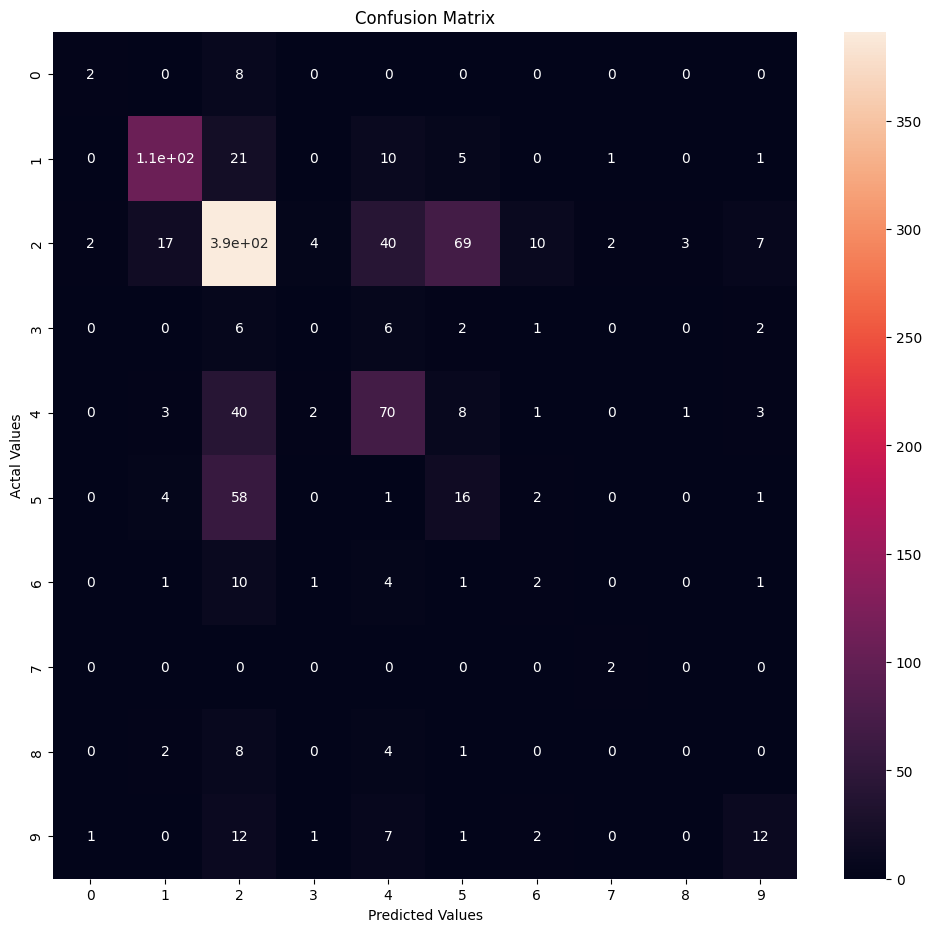

Accuracy:  0.602
Macro f1 score:  0.3494383318003186
Micro f1 score:  0.602


In [16]:
# SVM   CountVectorizer   TfidfTransformer    category
text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
                         ('tfidf', TfidfTransformer(use_idf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge',penalty='l2',alpha=0.0000001, n_iter_no_change=5, random_state=42)) ])

text_clf_svm.fit(train_text, train_category)
predicted_svm = text_clf_svm.predict(dev_text)



confusion_matrix = metrics.confusion_matrix(dev_category, predicted_svm)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['0','1','2','3','4','5','6','7','8','9'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
plt.figure(figsize=(12,11))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("Accuracy: ",np.mean(predicted_svm == dev_category))
print("Macro f1 score: ",metrics.f1_score(dev_category, predicted_svm, average="macro"))
print("Micro f1 score: ",metrics.f1_score(dev_category, predicted_svm, average="micro"))

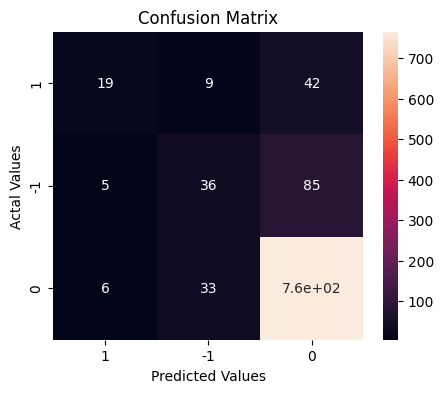

Accuracy:  0.82
Macro f1 score:  0.5450212726600073
Micro f1 score:  0.82


In [17]:
# Multinomial Naive bayes   CountVectorizer   TfidfTransformer    1 0 -1
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=0.026))])
text_clf = text_clf.fit(train_text, train_stance)

predicted = text_clf.predict(dev_text)

confusion_matrix = metrics.confusion_matrix(dev_stance, predicted)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['1','-1','0'], 
                     columns = ['1','-1','0'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("Accuracy: ",np.mean(predicted == dev_stance))
print("Macro f1 score: ",metrics.f1_score(dev_stance, predicted, average="macro"))
print("Micro f1 score: ",metrics.f1_score(dev_stance, predicted, average="micro"))

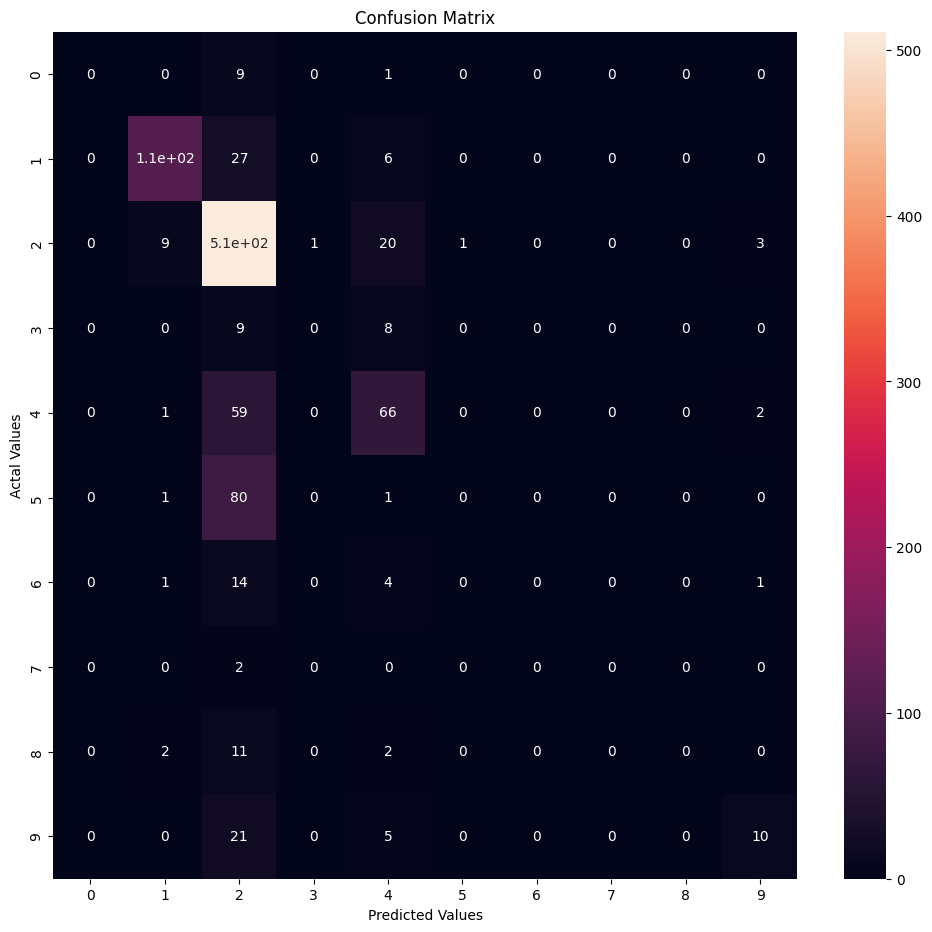

Accuracy:  0.699
Macro f1 score:  0.25523797534912585
Micro f1 score:  0.699


In [18]:
# Multinomial Naive bayes   CountVectorizer   TfidfTransformer    category
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=0.17)),])
text_clf = text_clf.fit(train_text, train_category)
predicted = text_clf.predict(dev_text)


confusion_matrix = metrics.confusion_matrix(dev_category, predicted)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['0','1','2','3','4','5','6','7','8','9'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
plt.figure(figsize=(12,11))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("Accuracy: ",np.mean(predicted == dev_category))
print("Macro f1 score: ",metrics.f1_score(dev_category, predicted, average="macro"))
print("Micro f1 score: ",metrics.f1_score(dev_category, predicted, average="micro"))

c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


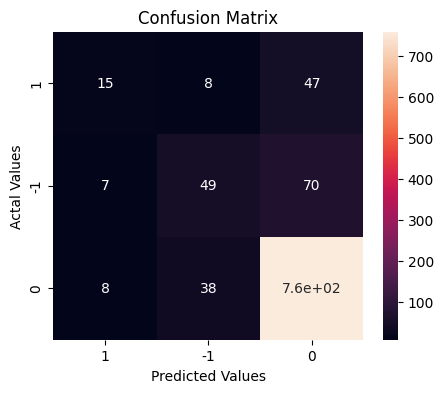

Accuracy: 0.822
Macro f1 score:  0.5487857726129807
Micro f1 score:  0.822


In [19]:
# LogisticRegression   CountVectorizer tfidf   catogray   and stance
from sklearn.linear_model import LogisticRegression
vectorizer = CountVectorizer()
vectorizer.fit(train_text)

X_train = vectorizer.transform(train_text)
X_test  = vectorizer.transform(dev_text)

classifier = LogisticRegression()
classifier.fit(X_train, train_stance)

res=classifier.predict(X_test)
score = classifier.score(X_test, dev_stance)


confusion_matrix = metrics.confusion_matrix(dev_stance, res)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['1','-1','0'], 
                     columns = ['1','-1','0'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("Accuracy:", score)
print("Macro f1 score: ",metrics.f1_score(dev_stance, res, average="macro"))
print("Micro f1 score: ",metrics.f1_score(dev_stance, res, average="micro"))


c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


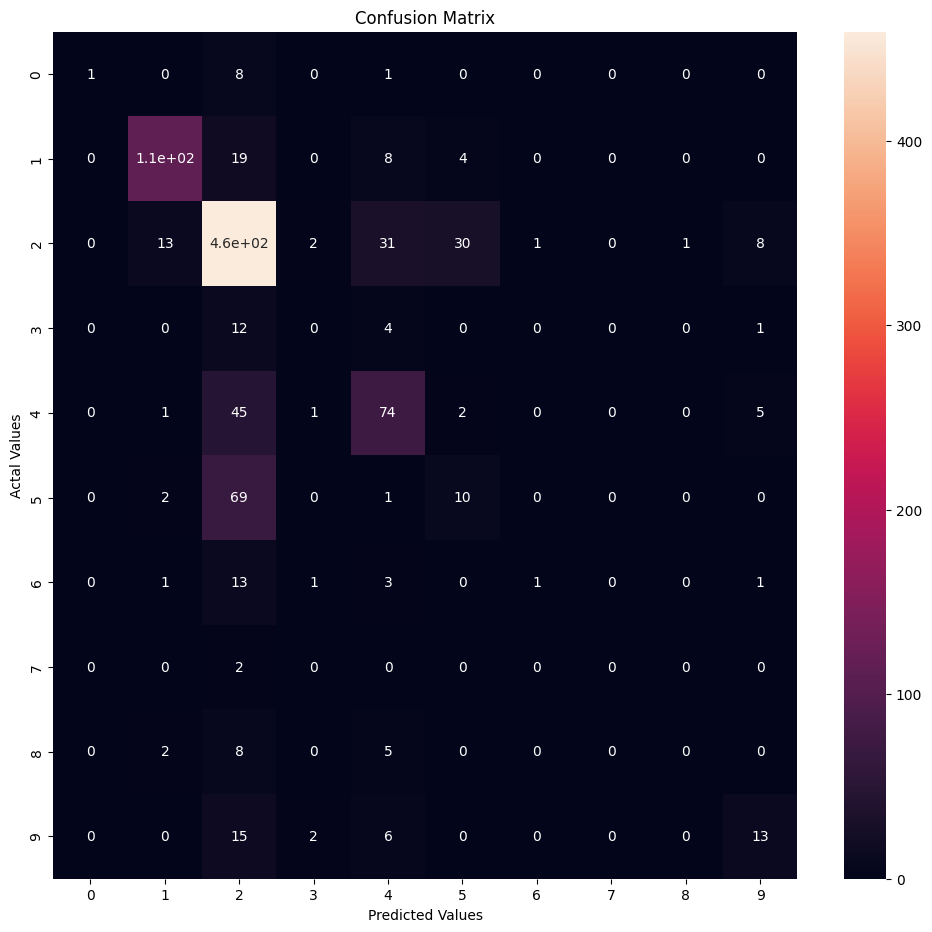

Accuracy: 0.672
Macro f1 score:  0.29906218028685616
Micro f1 score:  0.672


In [20]:
classifier = LogisticRegression()
classifier.fit(X_train, train_category)

score = classifier.score(X_test, dev_category)


res=classifier.predict(X_test)

confusion_matrix = metrics.confusion_matrix(dev_category, res)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['0','1','2','3','4','5','6','7','8','9'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
plt.figure(figsize=(12,11))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("Accuracy:", score)
print("Macro f1 score: ",metrics.f1_score(dev_category, res, average="macro"))
print("Micro f1 score: ",metrics.f1_score(dev_category, res, average="micro"))

In [21]:
## word to vector and padding then used svm
# https://github.com/susanli2016/NLP-with-Python/blob/master/Sentiment%20Analysis%20with%20RNN.ipynb
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
max_length,longest_element = max([(len(x),x) for x in train_text])
print(max_length)
tokenizer = Tokenizer(num_words=vocabsize,lower=True)
tokenizer.fit_on_texts(train_text)
seq_token = tokenizer.texts_to_sequences(train_text)
X_train1 =np.array( pad_sequences(seq_token, maxlen=max_length,padding="post"))


tokenizer2 = Tokenizer(num_words=vocabsize,lower=True)
tokenizer2.fit_on_texts(dev_text)
seq_token2 = tokenizer2.texts_to_sequences(dev_text)
X_test1 =np.array( pad_sequences(seq_token2, maxlen=max_length,padding="post"))
print(X_train1)

692
[[ 1576  1896    13 ...     0     0     0]
 [   37     7  1152 ...     0     0     0]
 [ 4886   259 10320 ...     0     0     0]
 ...
 [    5     8     1 ...     0     0     0]
 [  982   227    41 ...     0     0     0]
 [ 5712  3141  1157 ...     0     0     0]]


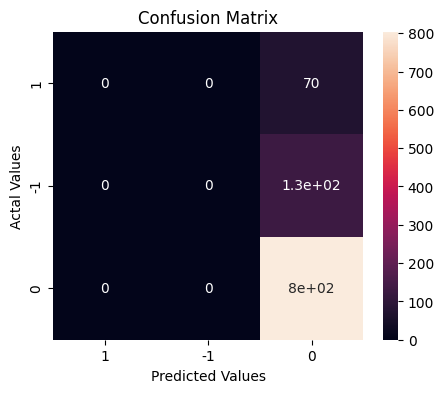

0.29711751662971175


In [22]:
# 1 0 -1
#Create a svm Classifier
from sklearn import svm

clf = svm.SVC(kernel='poly') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train1, train_stance)

#Predict the response for test dataset
y_pred = clf.predict(X_test1)
np.mean(y_pred==dev_stance)
confusion_matrix = metrics.confusion_matrix(dev_stance, y_pred)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['1','-1','0'], 
                     columns = ['1','-1','0'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print(metrics.f1_score(dev_stance, y_pred, average="macro"))

In [23]:
#1 0 -1
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.optimizers import Adam
embedding_size=32
model=Sequential()

model.add(Embedding(vocabsize, embedding_size, input_length=max_length))
model.add(LSTM(10))
model.add(Dense(1, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=.01),metrics=['accuracy'])
batch_size = 32
num_epochs = 2

X_valid, y_valid =np.array( X_train1[:batch_size]),np.array( train_stance[:batch_size])
X_train2, y_train2 =np.array( X_train1[batch_size:]),np.array( train_stance[batch_size:])

model.fit(X_train1, np.array(train_stance), batch_size=batch_size, epochs=num_epochs)
model.fit(X_train2, y_train2, validation_data=(X_valid,y_valid ), batch_size=batch_size, epochs=num_epochs)

Epoch 1/2
219/219 [==============================] - 43s 172ms/step - loss: 0.0000e+00 - accuracy: 0.7925
Epoch 2/2
219/219 [==============================] - 42s 190ms/step - loss: 0.0000e+00 - accuracy: 0.7925
Epoch 1/2
218/218 [==============================] - 45s 209ms/step - loss: 0.0000e+00 - accuracy: 0.7930 - val_loss: 0.0000e+00 - val_accuracy: 0.6875
Epoch 2/2
218/218 [==============================] - 48s 219ms/step - loss: 0.0000e+00 - accuracy: 0.7930 - val_loss: 0.0000e+00 - val_accuracy: 0.6875


32/32 [==============================] - 2s 56ms/step


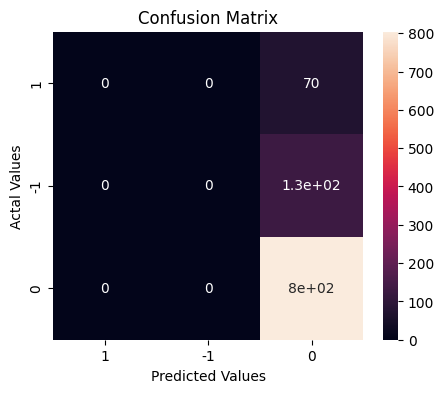

0.29711751662971175
Test accuracy: 0.8040000200271606


In [24]:
scores = model.evaluate(X_test1,np.array( dev_stance), verbose=0)
res=model.predict(X_test1)
confusion_matrix = metrics.confusion_matrix(dev_stance, res)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['1','-1','0'], 
                     columns = ['1','-1','0'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print(metrics.f1_score(dev_stance, res, average="macro"))
print('Test accuracy:', scores[1])

In [25]:
model = Sequential()
from keras.layers import Masking,SimpleRNN

# Embedding layer
model.add(
    Embedding(input_dim=vocabsize,
              input_length = max_length,
              output_dim=128,
              
              trainable=False,
              mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(SimpleRNN(128, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train1, np.array(train_stance), batch_size=1024, epochs=2)


Epoch 1/2
7/7 [==============================] - 89s 8s/step - loss: 0.0000e+00 - accuracy: 0.7925
Epoch 2/2
7/7 [==============================] - 55s 8s/step - loss: 0.0000e+00 - accuracy: 0.7925


32/32 [==============================] - 2s 67ms/step


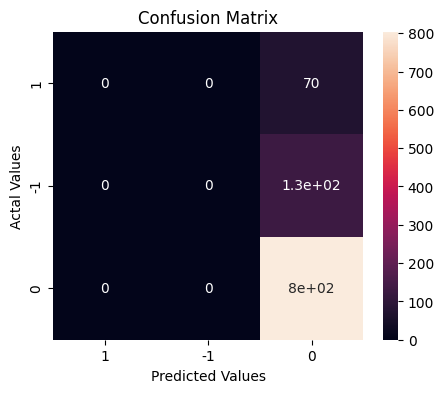

0.29711751662971175
Test accuracy: 0.8040000200271606


In [26]:
scores = model.evaluate(X_test1,np.array( dev_stance), verbose=0)
res=model.predict(X_test1)
confusion_matrix = metrics.confusion_matrix(dev_stance, res)
cm_df = pd.DataFrame(confusion_matrix,
                     index = ['1','-1','0'], 
                     columns = ['1','-1','0'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print(metrics.f1_score(dev_stance, res, average="macro"))
print('Test accuracy:', scores[1])

In [27]:
############################### padding to make all with same size#########################################
# traincont=train_text
# length = len(str(max(traincont, key=len)).split())
# print(length)
# for i in range(len(traincont)):
    
#     traincont[i]=str(traincont[i]).split()+["pad" for i in range(length-len(str(traincont[i]).split()))]
# testcont=dev_text
# for i in range(len(testcont)):
#     testcont[i]=str(testcont[i]).split()+["pad" for i in range(length-len(str(testcont[i]).split()))]

# traincont=[" ".join(i)for i in traincont]
# testcont=[" ".join(i)for i in testcont]
# traincont=np.array(traincont)
# testcont=np.array(testcont)

# make batches
# traincont = [traincont[i:i+100] for i in range(0,traincont.shape[0],100)]
# testcont = [testcont[i:i+100] for i in range(0,testcont.shape[0],100)]

In [28]:
# # Extract ELMo embeddings
# elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]
# traincont =[elmo(tf.constant(x))["elmo"] for x in traincont]
# testcont = [elmo(tf.constant(x))["elmo"] for x in testcont]

## reconstruct all batches
# traincont= np.concatenate(traincont, axis = 0)
# testcont = np.concatenate(testcont, axis = 0)# save elmo_train_new

# # save elmo_test_new
# pickle_out = open("elmo_train_03032019.pickle","wb")
# pickle.dump(traincont, pickle_out)
# pickle_out.close()

# pickle_out = open("elmo_test_03032019.pickle","wb")
# pickle.dump(testcont, pickle_out)
# pickle_out.close()

In [29]:
# # get the data from the saved file transfere to numpy with needed dimentions
# elmo_train_new=[] 
# with (open("elmo_train_03032019.pickle", "rb")) as openfile:
#     while True:
#         try:
#             elmo_train_new.append(pickle.load(openfile))
#         except EOFError:
#             break
# elmo_test_new=[] 
# with (open("elmo_test_03032019.pickle", "rb")) as openfile:
#     while True:
#         try:
#             elmo_test_new.append(pickle.load(openfile))
#         except EOFError:
#             break

# elmo_train_new=np.array(elmo_train_new)[0]
# elmo_test_new=np.array(elmo_test_new)[0]
# eL_Train=np.reshape(elmo_train_new, (len(elmo_train_new),108544))
# eL_Test=np.reshape(elmo_test_new, (len(elmo_test_new),108544))

In [30]:
# # SVM  elmo word embeddings    1 0 -1

# #Create a svm Classifier
# clf = svm.SVC(kernel='linear') # Linear Kernel

# #Train the model using the training sets
# clf.fit(eL_Train, train_stance)

# #Predict the response for test dataset
# y_pred = clf.predict(eL_Test)
# print(np.mean(y_pred==dev_stance))
# confusion_matrix = metrics.confusion_matrix(dev_stance, y_pred)
# cm_df = pd.DataFrame(confusion_matrix,
#                      index = ['1','-1','0'], 
#                      columns = ['1','-1','0'])
# plt.figure(figsize=(5,4))
# sns.heatmap(cm_df, annot=True)
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()
# print(f1_score(dev_stance, y_pred, average="macro"))